# 0. Uncertainty estimation using neural networks

In this notebook, we attempt to emulate the radiative transfer equation using neural networks.


Radiative transfer equation quantifies how the intensity, $I(s)$, changes along a ray,
\begin{equation}
\frac{dI}{ds} \ = \ \eta(s) \ - \ \chi(s) I(s),
\end{equation}
in which $\eta(s)$ is the emissivity and $\chi(s)$ is the opacity. This can be solved given a boundary condition $I_{\text{bdy}}$ at the beginning of the ray.


Usually this is written in terms of the optical depth, defined as
\begin{equation}
    \tau(z,s) \ \equiv \ \int_{z}^{s} ds' \ \chi(s')
\end{equation}
which simplifies the formal solution,

\begin{equation}
    I(s) \ = \ I_{\text{bdy}} e^{-\tau(s_{\text{bdy}},s)} \ + \ \int_{s_{\text{bdy}}}^{s} ds' \ \eta(s') e^{-\tau(s_{\text{bdy}},s')} .
\end{equation}

The aim of this work is to find a neural network to emulate the following function,

\begin{equation}
    \texttt{input} =
    \left(\begin{matrix}
        s    \\
        ds   \\
        \eta \\
        \chi \\
        I_{\text{bdy}}
    \end{matrix}\right) 
    \ \longrightarrow \
    \texttt{output} = I
\end{equation}




In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py as h5
import time
from datetime import datetime
import pandas as pd
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.8.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 60 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...
2022/03/29 10:22:09.657712 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/sciml-workshop-data
2022/03/29 10:22:09.673411 Opening GCS connection...
2022/03/29 10:22:09.840509 Mounting file system "sciml-workshop"...
2022/03/29 10:22:09.884396 File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  25370      0 --:--:-- --:--:-- --:--:-- 25370




Updated property [core/project].


---

# 1. Load the dataset

Our data are stored in the hdf files `Astronomy/RTE_train.h5` and `Astronomy/RTE_test.h5`. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
with h5.File(join(data_path, 'Astronomy/RTE_train.h5'), 'r') as F:
    train_Intensity = np.array(F['Intensity'])
    train_z = np.array(F['z'])
    train_dz = np.array(F['dz'])
    train_eta = np.array(F['eta'])
    train_chi = np.array(F['chi'])
    train_Ibdy = np.array(F['Ibdy'])
    
with h5.File(join(data_path, 'Astronomy/RTE_test.h5'), 'r') as F:
    test_Intensity = np.array(F['Intensity'])
    test_z = np.array(F['z'])
    test_dz = np.array(F['dz'])
    test_eta = np.array(F['eta'])
    test_chi = np.array(F['chi'])
    test_Ibdy = np.array(F['Ibdy'])
```
    
</p>
</details>

In [6]:
with h5.File(join(data_path, 'Astronomy/RTE_train.h5'), 'r') as F:
    train_Intensity = np.array(F['Intensity'])
    train_z = np.array(F['z'])
    train_dz = np.array(F['dz'])
    train_eta = np.array(F['eta'])
    train_chi = np.array(F['chi'])
    train_Ibdy = np.array(F['Ibdy'])
    
with h5.File(join(data_path, 'Astronomy/RTE_test.h5'), 'r') as F:
    test_Intensity = np.array(F['Intensity'])
    test_z = np.array(F['z'])
    test_dz = np.array(F['dz'])
    test_eta = np.array(F['eta'])
    test_chi = np.array(F['chi'])
    test_Ibdy = np.array(F['Ibdy'])

In [7]:
x_train = np.concatenate((train_z, train_dz, train_eta, train_chi, train_Ibdy), axis = -1)
y_train = np.stack(train_Intensity)

x_test = np.concatenate((test_z, test_dz, test_eta, test_chi, test_Ibdy), axis = -1)
y_test = np.stack(test_Intensity)

print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)

x train shape:  (10000, 256)
y train shape:  (10000, 1)
x test shape:  (1000, 256)
y test shape:  (1000, 1)


### Calculate the intensity using the formal solution

In [8]:
def solver_approx(eta, chi, dz, I_bdy):
    """
    A "quick-and-dirty" short-characteristics solver.
    """
    # Compute cell-averaged eta and chi
    eta_avg = 0.5*(eta[1:] + eta[:-1])
    chi_avg = 0.5*(chi[1:] + chi[:-1])
    # Approximate optical depth
    tau = np.cumsum(chi_avg*dz)   
    # Get target output by approximating the formal solution
    I = I_bdy*np.exp(-tau[-1]) + np.sum(eta_avg*np.exp(-tau)*dz)
    # Return target value
    return I

In [9]:
y_train_approx = []
for i in range(len(y_train)):
    y_train_approx.append(solver_approx (train_eta[i], train_chi[i], train_dz[i], train_Ibdy[i]))
    
y_test_approx = []
for i in range(len(y_test)):
    y_test_approx.append(solver_approx (test_eta[i], test_chi[i], test_dz[i], test_Ibdy[i]))
    
    
y_train_approx = np.stack(y_train_approx)
y_test_approx = np.stack(y_test_approx)

---

# 2. Build the network

We will build a simple linear regression model and a fully-connected neural network to compare their results. The output is continuous values and so we use 'mean squared error loss'. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(256,)))
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
model.add(tf.keras.layers.Dense(1,activation='linear',name='output'))


opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt,loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
startTime = datetime.now()
history = model.fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                      verbose=2,shuffle=False,callbacks=[early_stopping])
First_Trial = datetime.now() - startTime
print("\nTime taken: ", First_Trial)
```
    
</p>
</details>

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(256,)))
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
model.add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
model.add(tf.keras.layers.Dense(1,activation='linear',name='output'))


opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt,loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
startTime = datetime.now()
history = model.fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                      verbose=2,shuffle=False,callbacks=[early_stopping])
First_Trial = datetime.now() - startTime
print("\nTime taken: ", First_Trial)

Epoch 1/500
63/63 - 1s - loss: 0.3121 - val_loss: 0.1140 - 1s/epoch - 16ms/step
Epoch 2/500
63/63 - 0s - loss: 0.0869 - val_loss: 0.0756 - 217ms/epoch - 3ms/step
Epoch 3/500
63/63 - 0s - loss: 0.0597 - val_loss: 0.0540 - 222ms/epoch - 4ms/step
Epoch 4/500
63/63 - 0s - loss: 0.0459 - val_loss: 0.0448 - 232ms/epoch - 4ms/step
Epoch 5/500
63/63 - 0s - loss: 0.0380 - val_loss: 0.0376 - 246ms/epoch - 4ms/step
Epoch 6/500
63/63 - 0s - loss: 0.0316 - val_loss: 0.0323 - 215ms/epoch - 3ms/step
Epoch 7/500
63/63 - 0s - loss: 0.0268 - val_loss: 0.0273 - 218ms/epoch - 3ms/step
Epoch 8/500
63/63 - 0s - loss: 0.0231 - val_loss: 0.0235 - 213ms/epoch - 3ms/step
Epoch 9/500
63/63 - 0s - loss: 0.0202 - val_loss: 0.0213 - 221ms/epoch - 4ms/step
Epoch 10/500
63/63 - 0s - loss: 0.0182 - val_loss: 0.0198 - 240ms/epoch - 4ms/step
Epoch 11/500
63/63 - 0s - loss: 0.0166 - val_loss: 0.0184 - 275ms/epoch - 4ms/step
Epoch 12/500
63/63 - 0s - loss: 0.0153 - val_loss: 0.0172 - 253ms/epoch - 4ms/step
Epoch 13/500
63

---

# 3. Analyse results 

### Compare approximate intensity and prediction by the model

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(10, 7))

#plot 1:
plt.subplot(2,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(2,1,2)
plt.title('Prediction by neural network on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_pred, 'b', label = 'prediction')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

```
    
</p>
</details>

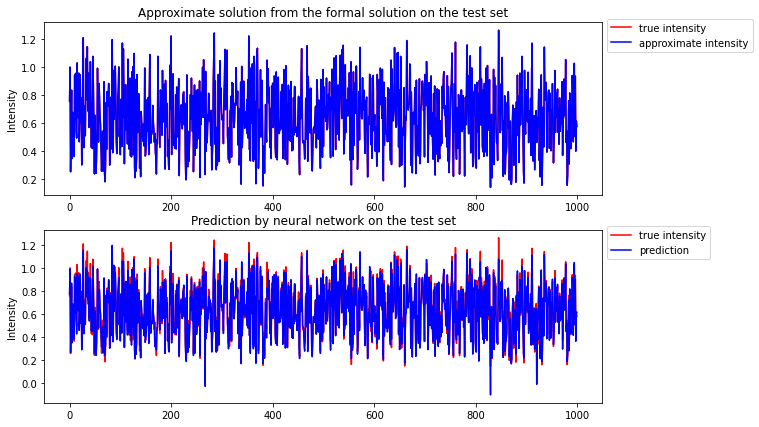

In [11]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(10, 7))

#plot 1:
plt.subplot(2,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(2,1,2)
plt.title('Prediction by neural network on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_pred, 'b', label = 'prediction')
plt.ylabel('Intensity')
plt.legend(bbox_to_anchor = (1., 1.05))


### Train multiple models for uncertainty of intensity

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

MODELS = {}
HISTORY = {}
for i in range(5):
    opt = tf.keras.optimizers.Adam(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
    
    MODELS[i] = tf.keras.models.Sequential()
    MODELS[i].add(tf.keras.Input(shape=(256,)))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
    # Define output layer
    MODELS[i].add(tf.keras.layers.Dense(1,activation='linear',name='output'))

    MODELS[i].compile(optimizer=opt,loss='mse')
    
    startTime = datetime.now()
    HISTORY[i] = MODELS[i].fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                          verbose=2,shuffle=False,callbacks=[early_stopping])
    First_Trial = datetime.now() - startTime
    print("\nTime taken: ", First_Trial)
```
    
</p>
</details>

In [12]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

MODELS = {}
HISTORY = {}
for i in range(5):
    opt = tf.keras.optimizers.Adam(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
    
    MODELS[i] = tf.keras.models.Sequential()
    MODELS[i].add(tf.keras.Input(shape=(256,)))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_1'))
    MODELS[i].add(tf.keras.layers.Dense(100,kernel_initializer=initializer,activation='tanh',name='dense_2'))
    # Define output layer
    MODELS[i].add(tf.keras.layers.Dense(1,activation='linear',name='output'))

    MODELS[i].compile(optimizer=opt,loss='mse')
    
    startTime = datetime.now()
    HISTORY[i] = MODELS[i].fit(x_train, y_train, epochs=500,batch_size=128,validation_split= 0.2,
                          verbose=2,shuffle=False,callbacks=[early_stopping])
    First_Trial = datetime.now() - startTime
    print("\nTime taken: ", First_Trial)

Epoch 1/500
63/63 - 1s - loss: 0.1396 - val_loss: 0.0619 - 752ms/epoch - 12ms/step
Epoch 2/500
63/63 - 0s - loss: 0.0518 - val_loss: 0.0410 - 224ms/epoch - 4ms/step
Epoch 3/500
63/63 - 0s - loss: 0.0383 - val_loss: 0.0333 - 249ms/epoch - 4ms/step
Epoch 4/500
63/63 - 0s - loss: 0.0316 - val_loss: 0.0290 - 223ms/epoch - 4ms/step
Epoch 5/500
63/63 - 0s - loss: 0.0267 - val_loss: 0.0257 - 243ms/epoch - 4ms/step
Epoch 6/500
63/63 - 0s - loss: 0.0234 - val_loss: 0.0233 - 242ms/epoch - 4ms/step
Epoch 7/500
63/63 - 0s - loss: 0.0210 - val_loss: 0.0215 - 246ms/epoch - 4ms/step
Epoch 8/500
63/63 - 0s - loss: 0.0191 - val_loss: 0.0201 - 267ms/epoch - 4ms/step
Epoch 9/500
63/63 - 0s - loss: 0.0176 - val_loss: 0.0187 - 240ms/epoch - 4ms/step
Epoch 10/500
63/63 - 0s - loss: 0.0162 - val_loss: 0.0176 - 241ms/epoch - 4ms/step
Epoch 11/500
63/63 - 0s - loss: 0.0151 - val_loss: 0.0164 - 265ms/epoch - 4ms/step
Epoch 12/500
63/63 - 0s - loss: 0.0140 - val_loss: 0.0151 - 257ms/epoch - 4ms/step
Epoch 13/500

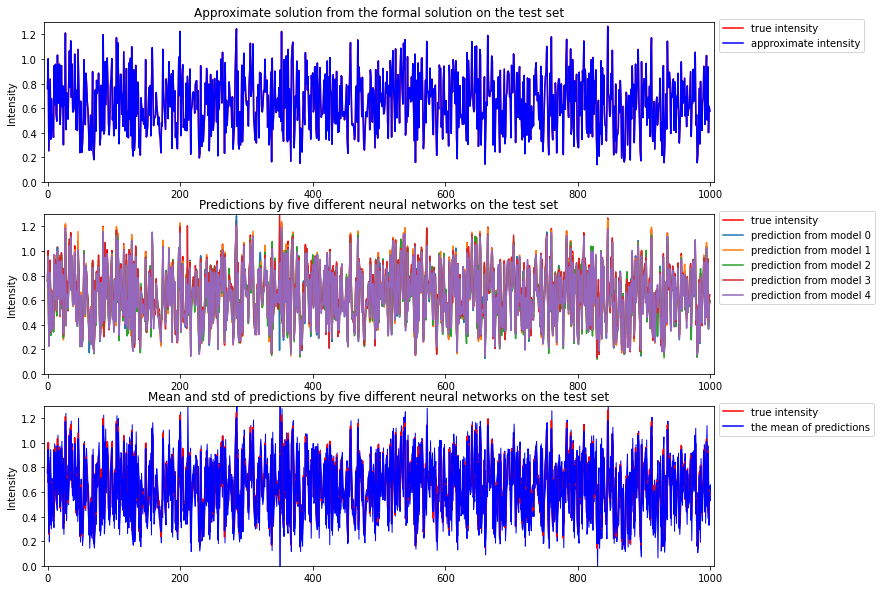

In [13]:
confidence_level = 2.57
TEST_PREDS = []
for i in range(5):
    TEST_PREDS.append(MODELS[i].predict(x_test))

test_mean = np.mean(np.concatenate(TEST_PREDS, axis = -1), axis = -1)
test_std = np.std(np.concatenate(TEST_PREDS, axis = -1), axis = -1)


#plot 1:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
plt.title('Approximate solution from the formal solution on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), y_test_approx, 'b', label = 'approximate intensity')
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))

#plot 2:
plt.subplot(3, 1, 2)
plt.title('Predictions by five different neural networks on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
for i in range(5):
    plt.plot(np.arange(len(y_test)), TEST_PREDS[i], label = 'prediction from model {}'.format(i))
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))


#plot 3:
plt.subplot(3, 1, 3)
plt.title('Mean and std of predictions by five different neural networks on the test set')
plt.plot(np.arange(len(y_test)), y_test, 'r', label = 'true intensity')
plt.plot(np.arange(len(y_test)), test_mean, 'b', label = 'the mean of predictions')
plt.fill_between(np.arange(len(test_mean)), (test_mean-confidence_level*test_std).reshape(-1), (test_mean+confidence_level*test_std).reshape(-1),color='blue', alpha=1.0)
plt.ylabel('Intensity')
plt.axis([-5, 1005, 0, 1.3])
plt.legend(bbox_to_anchor = (1., 1.05))

---

# 4. Exercises

* Train more models and compare the results
* Compute uncertainty using other machine learning methods such as Gaussian process or Bayesian approcaches and compare the results